In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q "/content/drive/MyDrive/eyes.zip" -d "/content/eyes"

In [1]:
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU, AveragePooling2D
from keras.layers import BatchNormalization, Activation
#from sklearn.model_selection import train_test_split
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input


import pandas as pd
from glob import glob
import cv2
from tqdm import tqdm
import os

print(tf.__version__)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-lxml33y2 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


2.7.0


In [2]:
# Constantes para el resto del programa
image_size = 75
channels = 3
seed = 1

batch_size = 32
validation_split = 0.1
test_size = 0.2

In [3]:
def mostrarEvolucion(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    pyplot.plot(loss)
    pyplot.plot(val_loss)
    pyplot.legend(['Training loss', 'Validation loss'])
    pyplot.show()

    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    pyplot.plot(acc)
    pyplot.plot(val_acc)
    pyplot.legend(['Training accuracy','Validation accuracy'])
    pyplot.show()

In [4]:
PATH = "./eyes/"
train_dir = os.path.join(PATH)
# Coge las imagenes por lotes, el tamaño por defecto del lote es de 32
train = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        validation_split=(0.3),
        subset="training",
        seed=42,
        image_size=(image_size,image_size)
    )
validation = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        validation_split=(0.3),
        subset="validation",
        seed=42,
        image_size=(image_size,image_size)
    )

Found 11525 files belonging to 2 classes.
Using 8068 files for training.
Found 11525 files belonging to 2 classes.
Using 3457 files for validation.


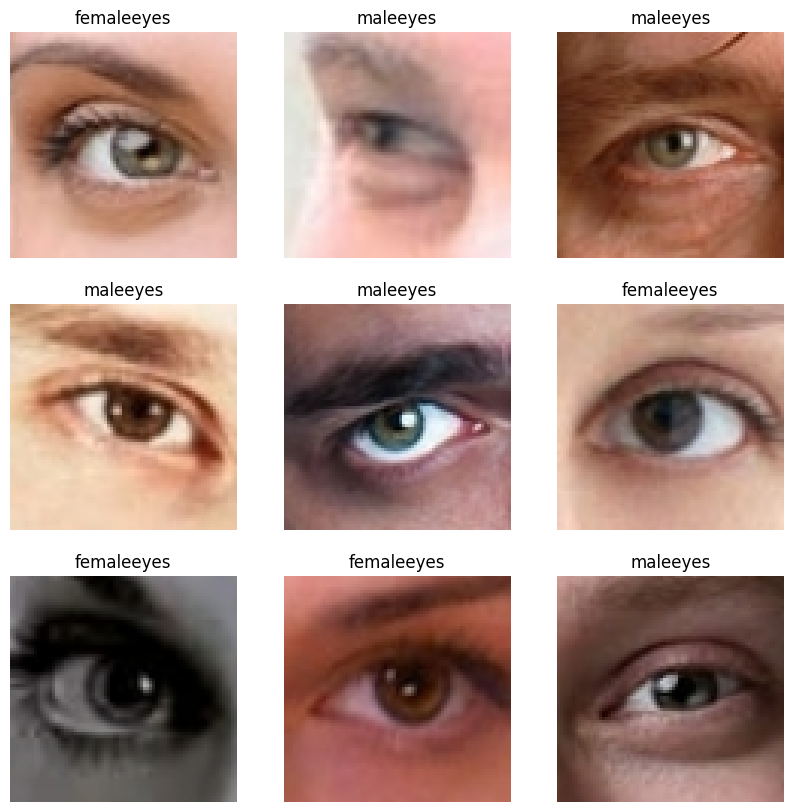

In [5]:
plt.figure(figsize=(10,10))
for images,labels in train.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train.class_names[labels[i]])
        plt.axis(False)
plt.show()

In [6]:
# Obtenemos el número de lotes iniciales para validación (el 30% del total)
val_batches = tf.data.experimental.cardinality(validation)
# Nos quedamos con 2/3 de esos lotes para test (el 20% del total)
test_batches = int( float(val_batches) * (2/3) )
test = validation.take(test_batches)
# Quitamos esos 2/3 de la validación para quedarnos con un 10% en validación 
# y 20% en test
validation = validation.skip(test_batches)

print('Número de lotes de validación: %d' % tf.data.experimental.cardinality(validation))
print('Número de lotes de test: %d' % tf.data.experimental.cardinality(test))

Número de lotes de validación: 37
Número de lotes de test: 72


In [7]:
def cargaDenseNet(dense_type = 'densenet121'):
    densenet = None
    if(dense_type == 'densenet121'):
        densenet = DenseNet121(
            input_shape=(image_size, image_size, channels),
            include_top = False,
            weights="imagenet",
            pooling="avg"
        ) 
    elif(dense_type == 'densenet169'):
        densenet = DenseNet169(
            input_shape=(image_size, image_size, channels),
            include_top = False,
            weights="imagenet",
            pooling="avg"
        ) 
    elif(dense_type == 'densenet201'):
        densenet = DenseNet201(
            input_shape=(image_size, image_size, channels),
            include_top = False,
            weights="imagenet",
            pooling="avg"
        )
    return densenet

## Trasfer learning solo con una capa de clasificación

In [ ]:
def model_frozen_only_classifier(epochs, dense_type):

    densenet = cargaDenseNet(dense_type)

    densenet.trainable = False

    inputs = keras.Input(shape=(image_size,image_size,channels))
    x = preprocess_input(inputs)
    x = densenet(x, training = False)
    outputs = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)

    model.summary()

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    hist = model.fit(
        train,
        epochs = epochs,
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist)

    print('RESULTADOS EN TEST:')

    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])

    del model, score, hist, densenet

29097984/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 75, 75, 3)        0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                              

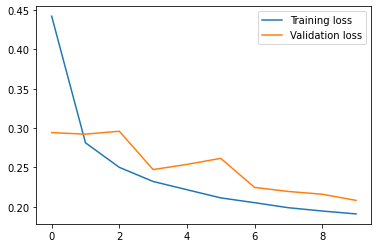

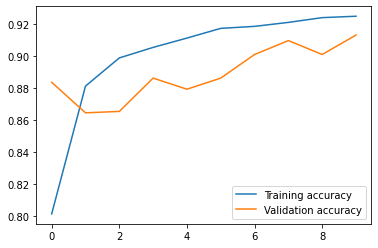

RESULTADOS EN TEST:
Pérdida en test: 0.23123663663864136
Accuracy en test: 0.9066840410232544


In [ ]:
model_frozen_only_classifier(10, 'densenet121')

51888128/51877672 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet169 (Functional)    (None, 1664)              12642

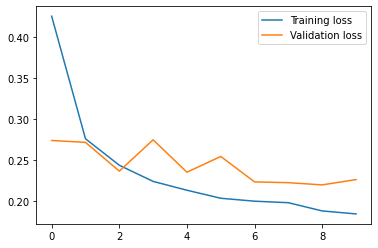

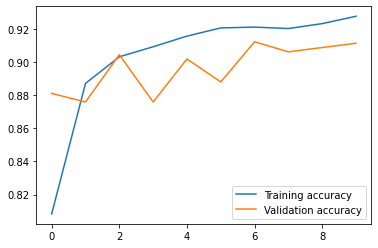

RESULTADOS EN TEST:
Pérdida en test: 0.21766424179077148
Accuracy en test: 0.9175347089767456


In [ ]:
model_frozen_only_classifier(10, 'densenet169')

74850304/74836368 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 1920)              18321

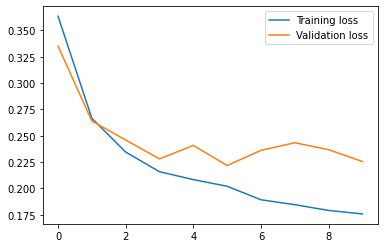

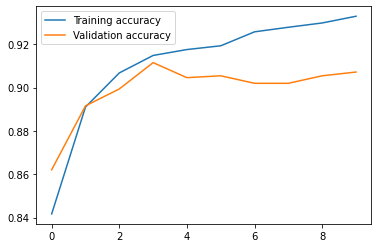

RESULTADOS EN TEST:
Pérdida en test: 0.2153015434741974
Accuracy en test: 0.9157986044883728


In [ ]:
model_frozen_only_classifier(10,'densenet201')

## Transfer learning con clasificador y data augmentation
Ahora comprobaremos como mejora el entrenamiento y la predicción al realizar *data augmentation*

In [ ]:
def model_frozen_only_classifier_data_augmentation(epochs, dense_type):

    # Generamos una capa de aumento de datos
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.1),
    ])

    # map aplica la función pasada como primer argumento a todos los elemetos
    # del dataset y devuelve un nuevo dataset que contiene los elementos
    # transformados
    train_aug = train.map(lambda x, y: (data_augmentation(x, training=True), y))

    densenet = cargaDenseNet(dense_type)

    densenet.trainable = False

    inputs = keras.Input(shape=(image_size,image_size,channels))
    x = preprocess_input(inputs)
    x = densenet(x, training = False)
    outputs = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    hist = model.fit(
        train_aug,
        # batch_size = batch_size,
        epochs = epochs,
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist)

    print('RESULTADOS EN TEST:')

    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])

    del model, score, hist, densenet

29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/10
253/253 [==============================] - 46s 115ms/step - loss: 0.4156 - accuracy: 0.8223 - val_loss: 0.2973 - val_accuracy: 0.8812
Epoch 2/10
253/253 [==============================] - 23s 92ms/step - loss: 0.3015 - accuracy: 0.8763 - val_loss: 0.2890 - val_accuracy: 0.8725
Epoch 3/10
253/253 [==============================] - 26s 102ms/step - loss: 0.2786 - accuracy: 0.8841 - val_loss: 0.3754 - val_accuracy: 0.8213
Epoch 4/10
253/253 [==============================] - 23s 92ms/step - loss: 0.2582 - accuracy: 0.8939 - val_loss: 0.2748 - val_accuracy: 0.8786
Epoch 5/10
253/253 [==============================] - 26s 102ms/step - loss: 0.2606 - accuracy: 0.8940 - val_loss: 0.2403 - val_accuracy: 0.9029
Epoch 6/10
253/253 [==============================] - 23s 91ms/step - loss: 0.2401 - accuracy: 0.9006 - val_loss: 0.2512 - val_accuracy: 0.8968
Epoch 7/10
253/253 [==============================] - 26s 101ms/step

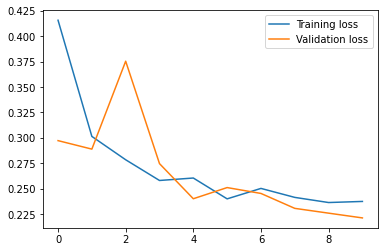

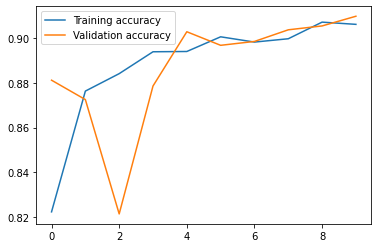

RESULTADOS EN TEST:
Pérdida en test: 0.24156342446804047
Accuracy en test: 0.90234375


In [ ]:
model_frozen_only_classifier_data_augmentation(10, 'densenet121')

51888128/51877672 [==============================] - 0s 0us/step
Epoch 1/10
253/253 [==============================] - 43s 126ms/step - loss: 0.4330 - accuracy: 0.8080 - val_loss: 0.2864 - val_accuracy: 0.8873
Epoch 2/10
253/253 [==============================] - 27s 108ms/step - loss: 0.2920 - accuracy: 0.8775 - val_loss: 0.3075 - val_accuracy: 0.8612
Epoch 3/10
253/253 [==============================] - 27s 108ms/step - loss: 0.2717 - accuracy: 0.8875 - val_loss: 0.2716 - val_accuracy: 0.8864
Epoch 4/10
253/253 [==============================] - 28s 108ms/step - loss: 0.2542 - accuracy: 0.8959 - val_loss: 0.2860 - val_accuracy: 0.8777
Epoch 5/10
253/253 [==============================] - 28s 109ms/step - loss: 0.2426 - accuracy: 0.9020 - val_loss: 0.2684 - val_accuracy: 0.8846
Epoch 6/10
253/253 [==============================] - 28s 109ms/step - loss: 0.2437 - accuracy: 0.9006 - val_loss: 0.2706 - val_accuracy: 0.8760
Epoch 7/10
253/253 [==============================] - 28s 109ms/s

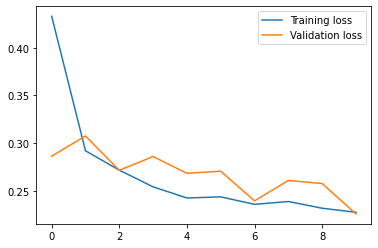

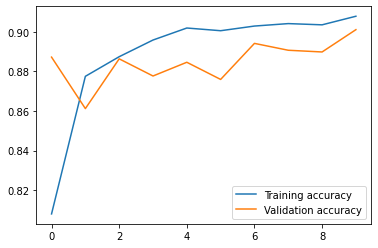

RESULTADOS EN TEST:
Pérdida en test: 0.22279092669487
Accuracy en test: 0.9118923544883728


In [ ]:
model_frozen_only_classifier_data_augmentation(10, 'densenet169')

In [ ]:
model_frozen_only_classifier_data_augmentation(10, 'densenet201')

74850304/74836368 [==============================] - 1s 0us/step
Epoch 1/10
253/253 [==============================] - 49s 140ms/step - loss: 0.4064 - accuracy: 0.8163 - val_loss: 0.3786 - val_accuracy: 0.8257
Epoch 2/10
100/253 [==========>...................] - ETA: 16s - loss: 0.3247 - accuracy: 0.8594

## Fine tuning - Adam
A continuación realizaremos fine-tuning partiendo de la red anterior, con data augmentation. Para ello partinermos de la red anterior y descongelaremos el último bloque denso.

Para el aumento de datos se aplicarán las transformaciones de giro horizontal y rotación.

Al estar trabajando con datasets de tensorflow que funcionan generando batches, para aplicar aumento de datos, lo haremos usando el método `dataset.map` solo sobre el dataset de train, para que las transformaciones solo se apliquen a este. Esto nos devolverá un nuevo generador de lotes (`dataset`) que aplicará las transformaciones a las imágenes que genere.

Para realizar fine-tuning:
1. Se entrenará SOLO la capa de clasificación durante unas pocas épocas
2. Se descongelará el último bloque denso de la red DenseNet, el cual contiene todas las capas en las que aparezaca 'conv5'
3. Se volverá a entrenar el modelo comenzando por la época en la que terminó el entrenamiento del clasificador del punto 1

In [ ]:
def model_defrost_conv5_data_augmentation(epochs_frozen, epochs_defrost, dense_type):
    
    # Generamos una capa de aumento de datos
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.1),
    ])
    
    # map aplica la función pasada como primer argumento a todos los elemetos
    # del dataset y devuelve un nuevo dataset que contiene los elementos
    # transformados
    train_aug = train.map(lambda x, y: (data_augmentation(x, training=True), y))
        
    densenet = cargaDenseNet(dense_type)

    densenet.trainable = False
    
    #densenet.summary()

    inputs = keras.Input(shape=(image_size,image_size,channels))
    x = preprocess_input(inputs)
    x = densenet(x, training = False)
    outputs = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    hist = model.fit(
        train_aug,
        epochs = epochs_frozen,
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist)

    print('RESULTADOS EN TEST:')
    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])

    del score
    
    total_epochs = epochs_frozen + epochs_defrost

    my_layer = model.get_layer(dense_type)
    my_layer.trainable = True

    for layer in my_layer.layers:
        print(layer.name)
        if 'conv5' in layer.name:
            layer.trainable = True
        else:
            layer.trainable = False

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.Adam(2e-5),
        metrics=["accuracy"]
    )

    model.summary()

    hist_fine = model.fit(
        train,
        epochs = total_epochs,
        initial_epoch = hist.epoch[-1],
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist_fine)

    print('RESULTADOS EN TEST:')

    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])


    del model, score, hist, densenet, hist_fine

29097984/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 75, 75, 3)        0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                              

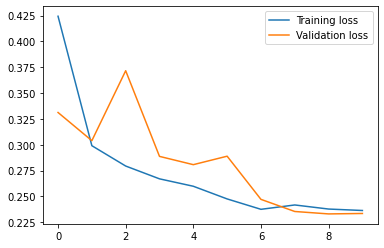

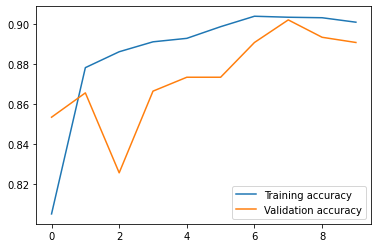

RESULTADOS EN TEST:
Pérdida en test: 0.24996274709701538
Accuracy en test: 0.8993055820465088
input_1
zero_padding2d
conv1/conv
conv1/bn
conv1/relu
zero_padding2d_1
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool

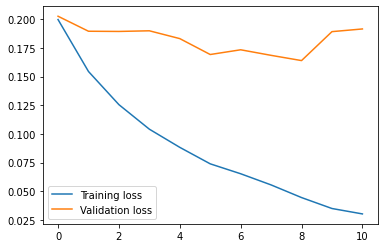

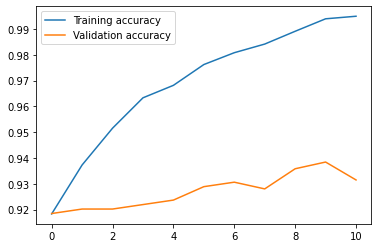

RESULTADOS EN TEST:
Pérdida en test: 0.18454168736934662
Accuracy en test: 0.9361979365348816


In [ ]:
model_defrost_conv5_data_augmentation(10, 10, 'densenet121')

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_16 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 tf.nn.bias_add_8 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_17 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 densenet169 (Functional)    (None, 1664)              12642880  
                                                           

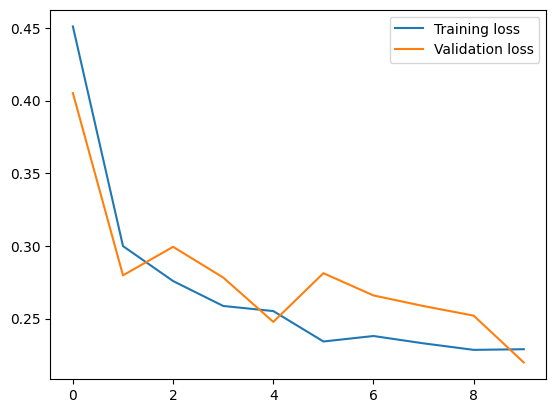

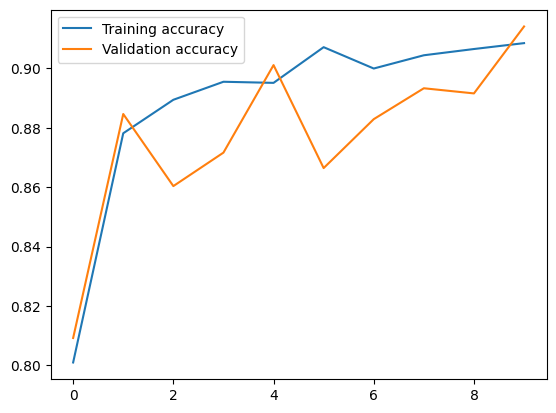

RESULTADOS EN TEST:
Pérdida en test: 0.2256808876991272
Accuracy en test: 0.9123263955116272
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_16 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 tf.nn.bias_add_8 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_17 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 densenet169 (Functional)    (No

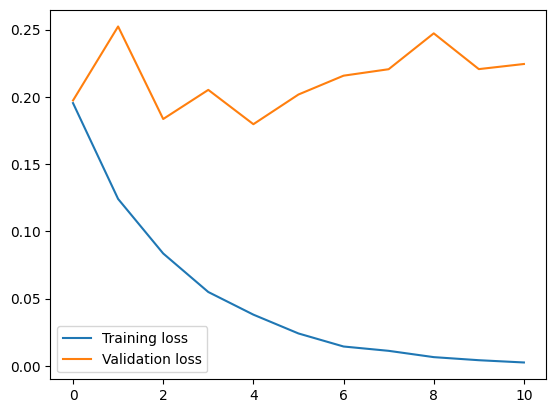

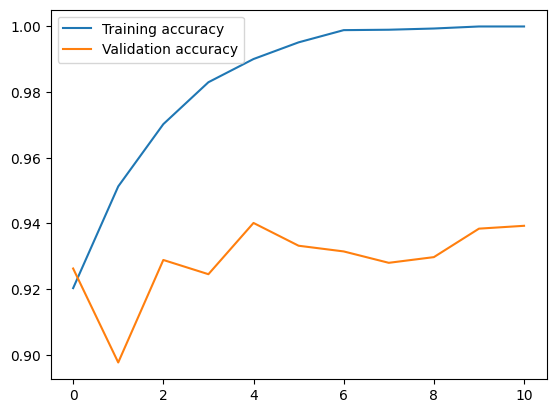

RESULTADOS EN TEST:
Pérdida en test: 0.1837015300989151
Accuracy en test: 0.9496527910232544


In [ ]:
model_defrost_conv5_data_augmentation(10, 10, 'densenet169')

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_18 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 tf.nn.bias_add_9 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_19 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 densenet201 (Functional)    (None, 1920)              18321984  
                                                           

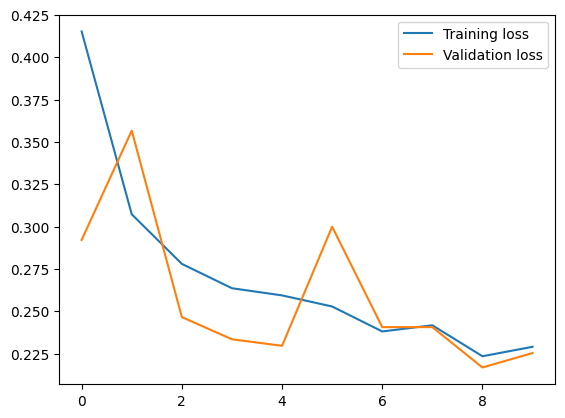

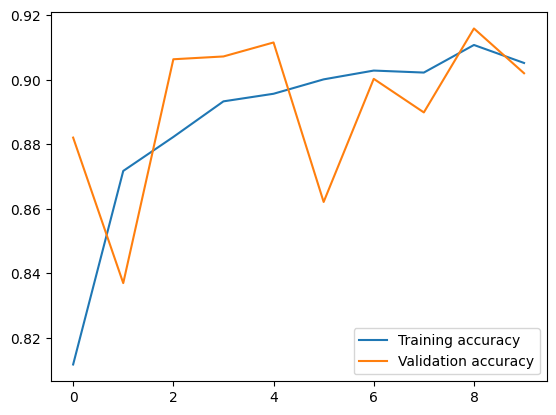

RESULTADOS EN TEST:
Pérdida en test: 0.22462821006774902
Accuracy en test: 0.9118923544883728
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_18 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 tf.nn.bias_add_9 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_19 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 densenet201 (Functional)    (N

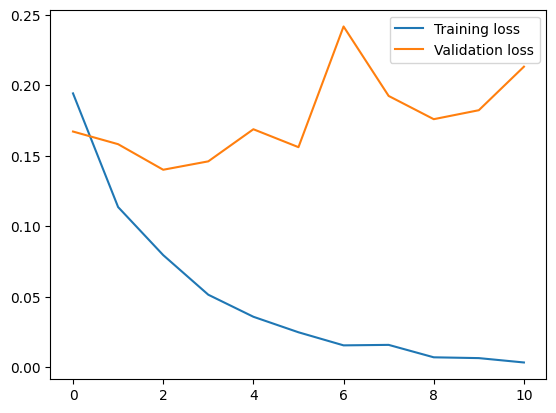

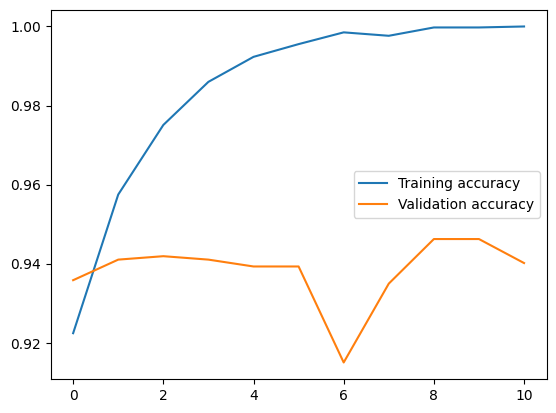

RESULTADOS EN TEST:
Pérdida en test: 0.17965926229953766
Accuracy en test: 0.9470486044883728


In [ ]:
model_defrost_conv5_data_augmentation(10, 10, 'densenet201')

In [ ]:
def model_defrost_conv5_data_augmentation_lr(epochs_frozen, epochs_defrost, dense_type):

    ############################################################
    ### Transfer learning
    ############################################################
    lr = 0.0001
    
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.1),
    ])

    # map aplica la función pasada como primer argumento a todos los elemetos
    # del dataset y devuelve un nuevo dataset que contiene los elementos
    # transformados
    train_aug = train.map(lambda x, y: (data_augmentation(x, training=True), y))
    
    # for image, _ in train.take(1):
    #     plt.figure(figsize=(10, 10))
    #     first_image = image[0]
    #     for i in range(9):
    #         ax = plt.subplot(3, 3, i + 1)
    #         augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    #         plt.imshow(augmented_image[0] / 255)
    #         plt.axis('off')
        
    densenet = cargaDenseNet(dense_type)

    densenet.trainable = False

    inputs = keras.Input(shape=(image_size,image_size,3))
    #x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = densenet(x, training = False)
    outputs = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=["accuracy"]
    )

    hist = model.fit(
        train_aug,
        # batch_size = batch_size,
        epochs = epochs_frozen,
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist)

    print('RESULTADOS EN TEST:')
    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])

    del score

    ############################################################
    ### Fine-tuning
    ############################################################

    total_epochs = epochs_frozen + epochs_defrost

    my_layer = model.get_layer(dense_type)
    my_layer.trainable = True

    for layer in my_layer.layers:
        if 'conv5' in layer.name:
            #print(layer.name)
            layer.trainable = True
        else:
            layer.trainable = False

    # Cuantas capas tiene el modelo DenseNet121
    print("Número de capas de DenseNet121: ", len(densenet.layers))

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr/10),
        metrics=["accuracy"]
    )

    model.summary()

    hist_fine = model.fit(
        train,
        # batch_size = batch_size,
        epochs = total_epochs,
        initial_epoch = hist.epoch[-1],
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist_fine)

    print('RESULTADOS EN TEST:')

    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])


    del model, score, hist, densenet, hist_fine

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_20 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 tf.nn.bias_add_10 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.math.truediv_21 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                          

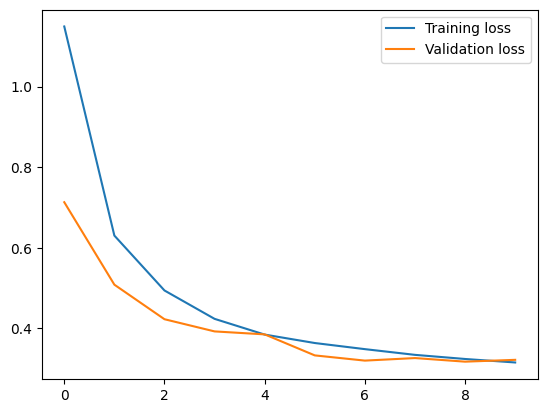

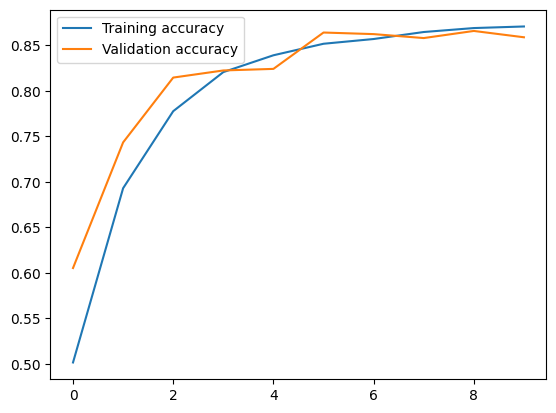

RESULTADOS EN TEST:
Pérdida en test: 0.33368784189224243
Accuracy en test: 0.8563368320465088
Número de capas de DenseNet121:  428
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_20 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 tf.nn.bias_add_10 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.math.truediv_21 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                           

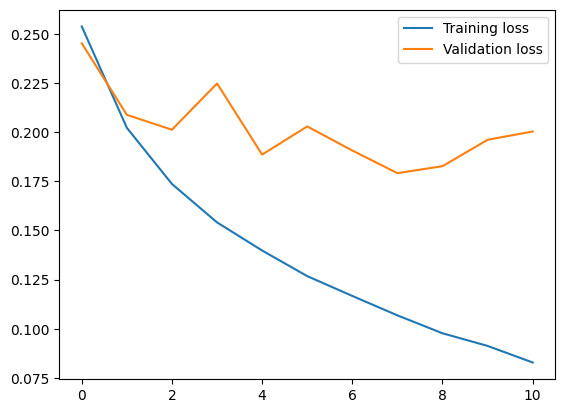

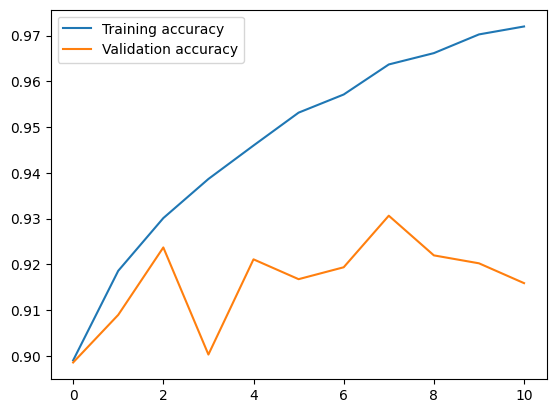

RESULTADOS EN TEST:
Pérdida en test: 0.20703834295272827
Accuracy en test: 0.9192708134651184


In [ ]:
model_defrost_conv5_data_augmentation_lr(10, 10, 'densenet121')

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_22 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 tf.nn.bias_add_11 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.math.truediv_23 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 densenet169 (Functional)    (None, 1664)              12642880  
                                                          

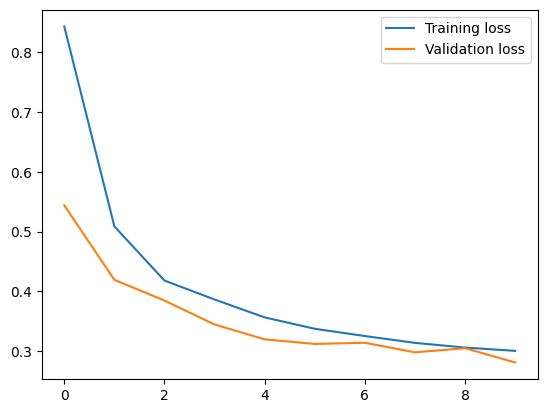

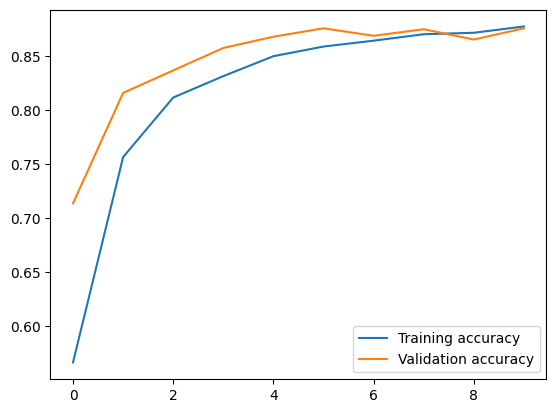

RESULTADOS EN TEST:
Pérdida en test: 0.30469056963920593
Accuracy en test: 0.8693576455116272
Número de capas de DenseNet121:  596
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_22 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 tf.nn.bias_add_11 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.math.truediv_23 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                           

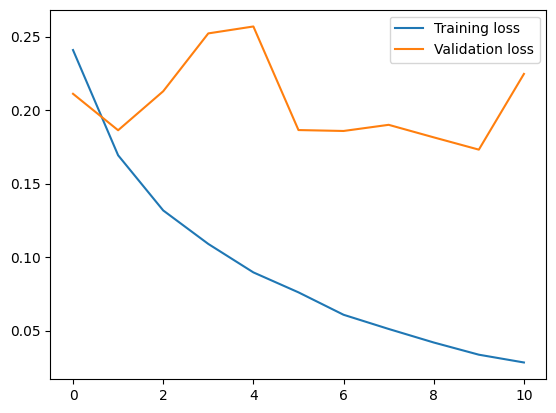

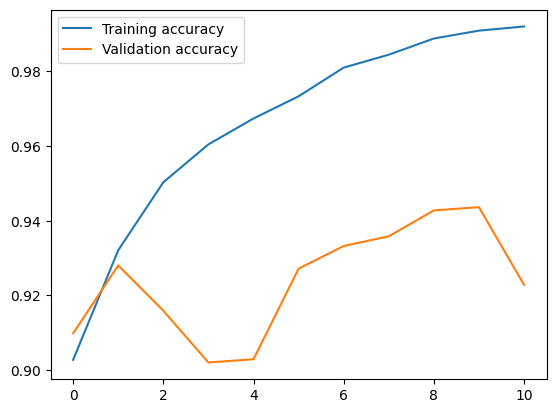

RESULTADOS EN TEST:
Pérdida en test: 0.20161427557468414
Accuracy en test: 0.9270833134651184


In [ ]:
model_defrost_conv5_data_augmentation_lr(10, 10, 'densenet169')

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_24 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 tf.nn.bias_add_12 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.math.truediv_25 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 densenet201 (Functional)    (None, 1920)              18321984  
                                                          

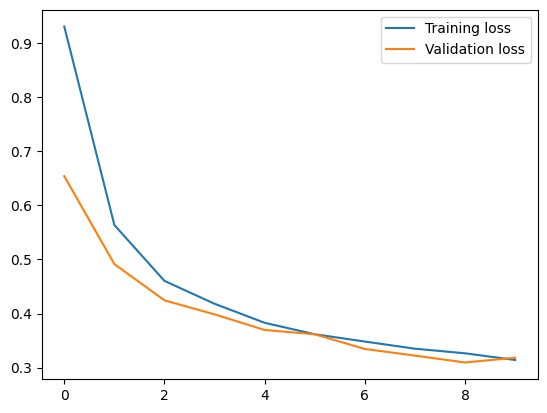

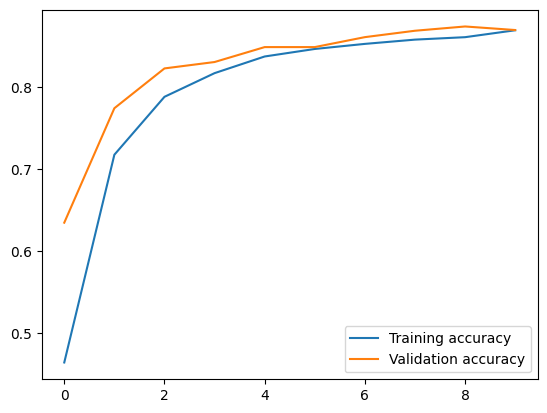

RESULTADOS EN TEST:
Pérdida en test: 0.3145042359828949
Accuracy en test: 0.859375
Número de capas de DenseNet121:  708
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_24 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 tf.nn.bias_add_12 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.math.truediv_25 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 den

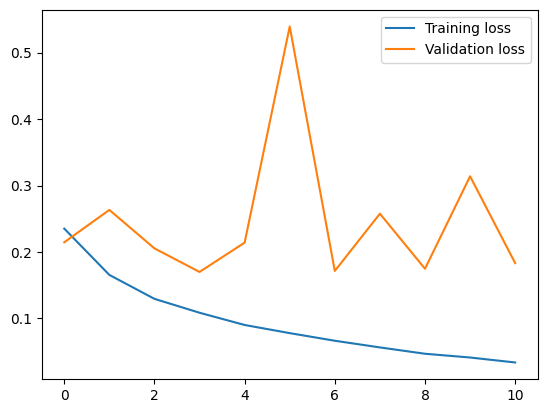

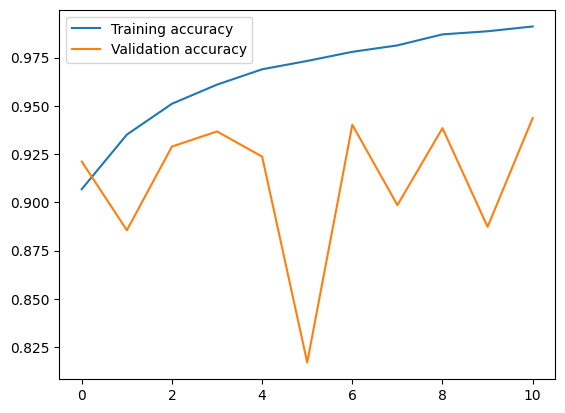

RESULTADOS EN TEST:
Pérdida en test: 0.15959157049655914
Accuracy en test: 0.9440104365348816


In [ ]:
model_defrost_conv5_data_augmentation_lr(10, 10, 'densenet201')

## Fine tuning - SGD
En este modelo, para la parte de fine-tuning, una vez descongelada el último bloque *denso*, usaremos como función de optimización la función de *Stochastic Gradient Descent* con un learning rate de 0.001 aplicando un momentum de *Nesterov* de 0.9. 

Se han elegido estos parámetros y esta función de optimización porque es la que se usa en el entrenamiento de DenseNet con ImageNet en las últimas épocas, según el paper oficial.

In [ ]:
def model_defrost_conv5_lr_SGD(epochs_frozen, epochs_defrost, dense_type):

    ############################################################
    ### Transfer learning
    ############################################################        
    densenet = cargaDenseNet(dense_type)

    densenet.trainable = False

    inputs = keras.Input(shape=(image_size,image_size,channels))
    x = preprocess_input(inputs)
    x = densenet(x, training = False)
    outputs = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    hist = model.fit(
        train,
        epochs = epochs_frozen,
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist)

    print('RESULTADOS EN TEST:')
    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])

    del score

    ############################################################
    ### Fine-tuning
    ############################################################

    total_epochs = epochs_frozen + epochs_defrost

    my_layer = model.get_layer(dense_type)
    my_layer.trainable = True

    for layer in my_layer.layers:
        if 'conv5' in layer.name:
            #print(layer.name)
            layer.trainable = True
        else:
            layer.trainable = False

    # Cuantas capas tiene el modelo DenseNet121
    # print("Número de capas de DenseNet121: ", len(densenet.layers))

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.001
                                            , nesterov = True
                                            , momentum = 0.9),
        metrics=["accuracy"]
    )

    model.summary()

    hist = model.fit(
        train,
        epochs = total_epochs,
        initial_epoch = hist.epoch[-1],
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist)

    print('RESULTADOS EN TEST:')

    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])


    del model, score, hist, densenet

29097984/29084464 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 75, 75, 3)        0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                              

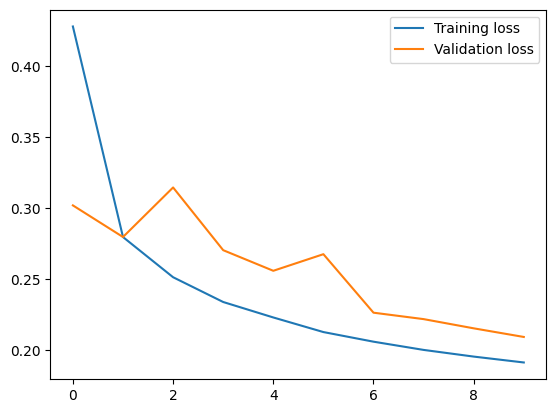

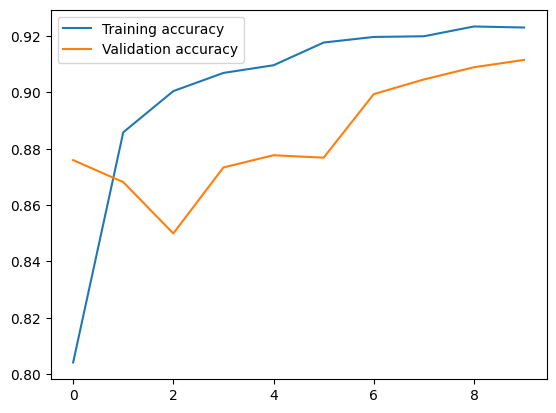

RESULTADOS EN TEST:
Pérdida en test: 0.23025411367416382
Accuracy en test: 0.9084201455116272
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 75, 75, 3)        0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                 

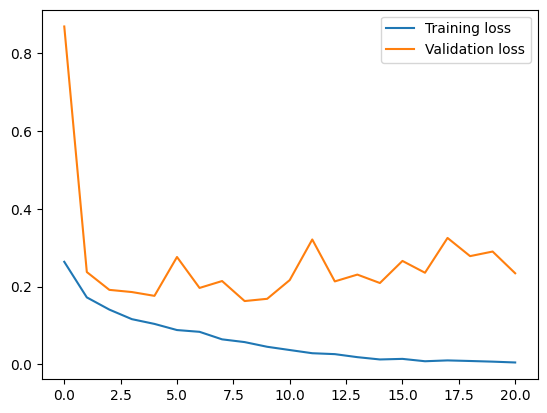

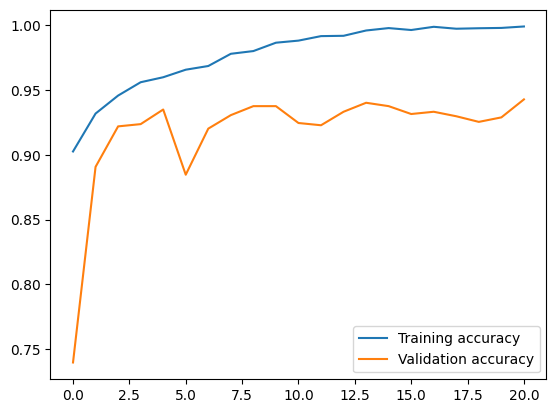

RESULTADOS EN TEST:
Pérdida en test: 0.23817232251167297
Accuracy en test: 0.9383680820465088


In [ ]:
model_defrost_conv5_lr_SGD(10, 20, 'densenet121')

51888128/51877672 [==============================] - 7s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet169 (Functional)    (None, 1664)              12642

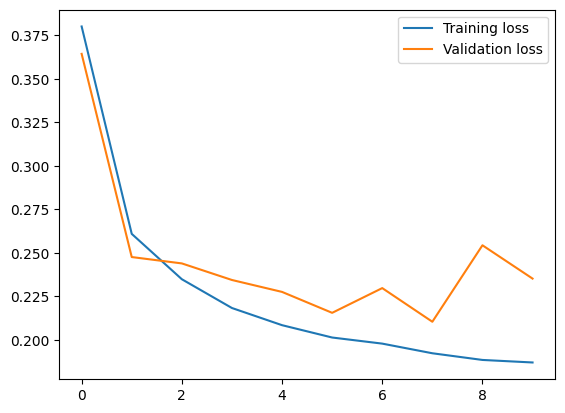

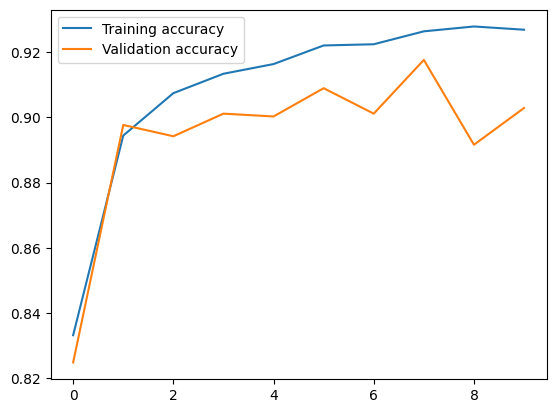

RESULTADOS EN TEST:
Pérdida en test: 0.22949732840061188
Accuracy en test: 0.9118923544883728
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet169 (Functional)    (N

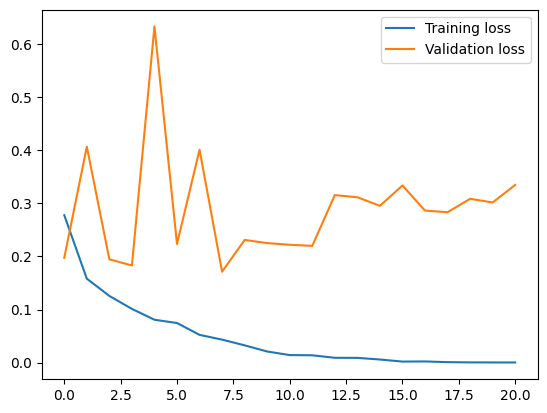

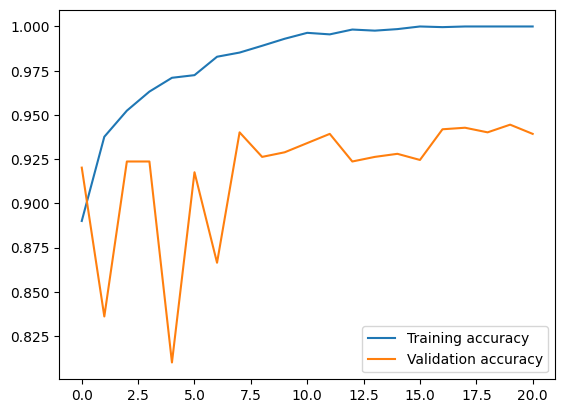

RESULTADOS EN TEST:
Pérdida en test: 0.21926014125347137
Accuracy en test: 0.9539930820465088


In [ ]:
model_defrost_conv5_lr_SGD(10, 20, 'densenet169')

74850304/74836368 [==============================] - 10s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 1920)              1832

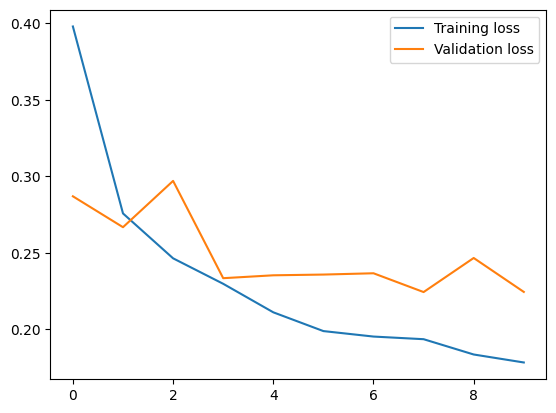

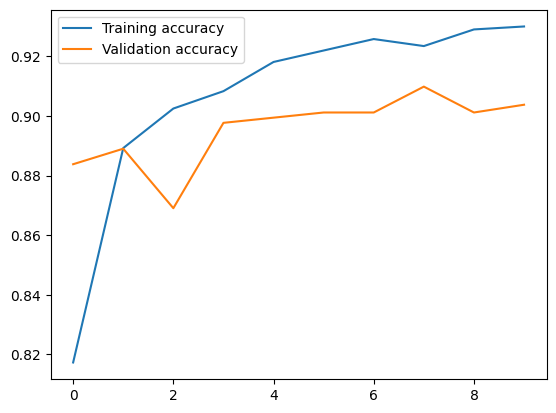

RESULTADOS EN TEST:
Pérdida en test: 0.21682852506637573
Accuracy en test: 0.9123263955116272
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (N

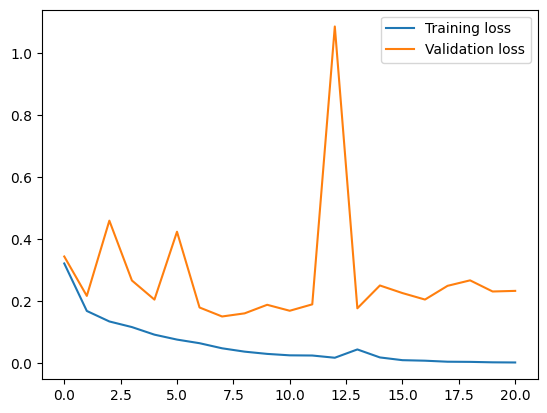

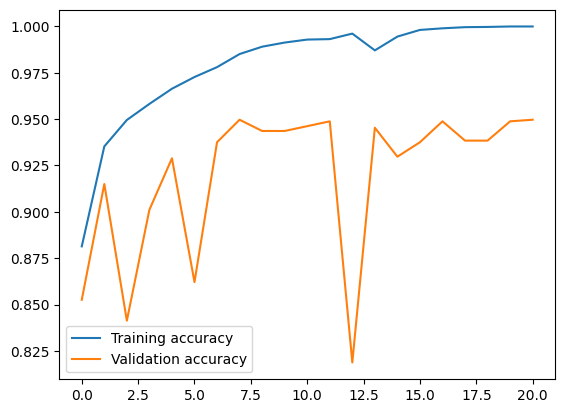

RESULTADOS EN TEST:
Pérdida en test: 0.22042196989059448
Accuracy en test: 0.9513888955116272


In [ ]:
model_defrost_conv5_lr_SGD(10, 20, 'densenet201')

Usaremos *checkpoints* ya que aparecen picos en la validación y nos interesa quedarnos con el mejor resultado.

In [ ]:
def model_defrost_conv5_data_augmentation_lr_SGD(epochs_frozen, epochs_defrost, dense_type):

    ############################################################
    ### Transfer learning
    ############################################################

    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.1),
    ])

    # map aplica la función pasada como primer argumento a todos los elemetos
    # del dataset y devuelve un nuevo dataset que contiene los elementos
    # transformados
    train_aug = train.map(lambda x, y: (data_augmentation(x, training=True), y))
    
    # for image, _ in train.take(1):
    #     plt.figure(figsize=(10, 10))
    #     first_image = image[0]
    #     for i in range(9):
    #         ax = plt.subplot(3, 3, i + 1)
    #         augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    #         plt.imshow(augmented_image[0] / 255)
    #         plt.axis('off')
        
    densenet = cargaDenseNet(dense_type)

    densenet.trainable = False

    inputs = keras.Input(shape=(image_size,image_size,channels))
    x = preprocess_input(inputs)
    x = densenet(x, training = False)
    outputs = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    hist = model.fit(
        train_aug,
        # batch_size = batch_size,
        epochs = epochs_frozen,
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist)

    print('RESULTADOS EN TEST:')
    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])

    del score

    ############################################################
    ### Fine-tuning
    ############################################################

    total_epochs = epochs_frozen + epochs_defrost
    
    checkpoint_filepath = '/tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='accuracy',
        mode='max',
        save_best_only=True
    )

    my_layer = model.get_layer(dense_type)
    my_layer.trainable = True

    for layer in my_layer.layers:
        if 'conv5' in layer.name:
            #print(layer.name)
            layer.trainable = True
        else:
            layer.trainable = False

    # Cuantas capas tiene el modelo DenseNet121
    # print("Número de capas de DenseNet121: ", len(densenet.layers))

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=0.001,
            nesterov = True,
            momentum = 0.9
        ),
        metrics=["accuracy"]
    )

    model.summary()

    hist_fine = model.fit(
        train_aug,
        # batch_size = batch_size,
        epochs = total_epochs,
        callbacks=[model_checkpoint_callback],
        initial_epoch = hist.epoch[-1],
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist_fine)

    print('RESULTADOS EN TEST:')

    model.load_weights(checkpoint_filepath)
    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])


    del model, score, hist, densenet, hist_fine

29097984/29084464 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 1024)              70375

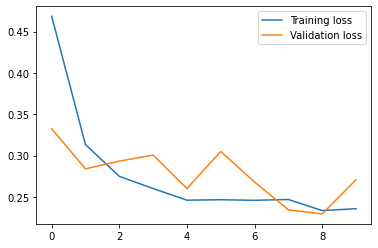

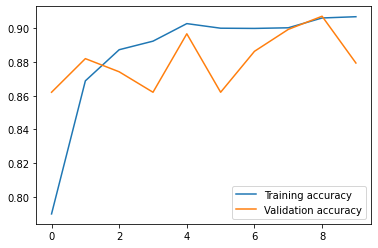

RESULTADOS EN TEST:
Pérdida en test: 0.28300851583480835
Accuracy en test: 0.8815104365348816
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (N

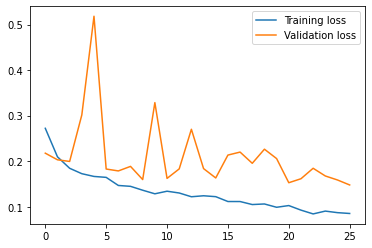

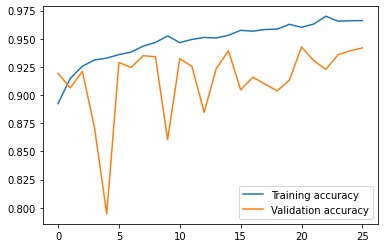

RESULTADOS EN TEST:
Pérdida en test: 0.17905226349830627
Accuracy en test: 0.9296875


In [ ]:
model_defrost_conv5_data_augmentation_lr_SGD(10, 25, 'densenet121')

51888128/51877672 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet169 (Functional)    (None, 1664)              12642

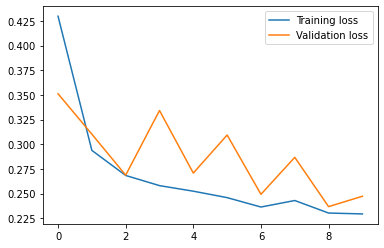

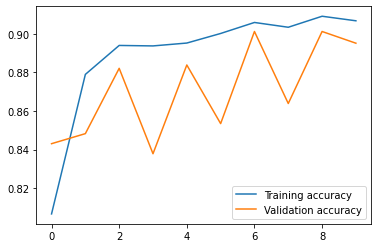

RESULTADOS EN TEST:
Pérdida en test: 0.2325606644153595
Accuracy en test: 0.9110243320465088
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet169 (Functional)    (No

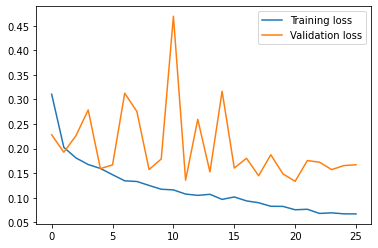

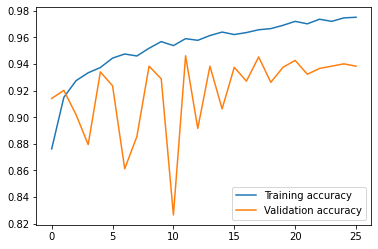

RESULTADOS EN TEST:
Pérdida en test: 0.17393365502357483
Accuracy en test: 0.9483506679534912


In [ ]:
model_defrost_conv5_data_augmentation_lr_SGD(10, 25, 'densenet169')

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_14 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 tf.nn.bias_add_7 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_15 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 densenet201 (Functional)    (None, 1920)              18321984  
                                                           

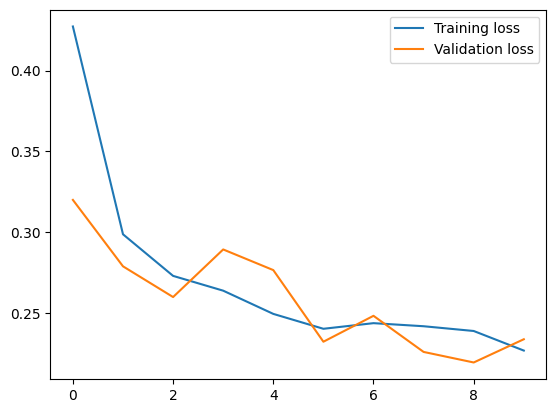

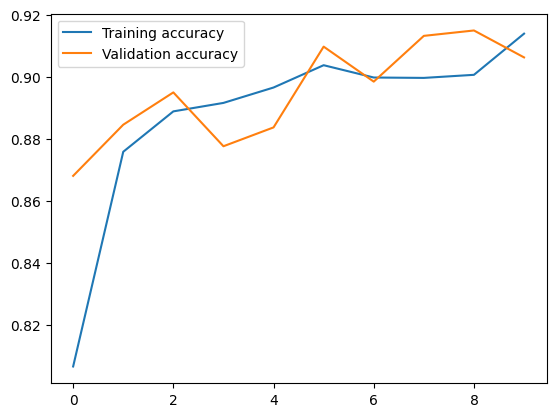

RESULTADOS EN TEST:
Pérdida en test: 0.23248052597045898
Accuracy en test: 0.9071180820465088
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_14 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 tf.nn.bias_add_7 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_15 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 densenet201 (Functional)    (N

253/253 [==============================] - 23s 93ms/step - loss: 0.0288 - accuracy: 0.9876 - val_loss: 0.1602 - val_accuracy: 0.9549
Epoch 57/60
253/253 [==============================] - 23s 92ms/step - loss: 0.0309 - accuracy: 0.9891 - val_loss: 0.1812 - val_accuracy: 0.9454
Epoch 58/60
253/253 [==============================] - 23s 92ms/step - loss: 0.0366 - accuracy: 0.9860 - val_loss: 0.2405 - val_accuracy: 0.9315
Epoch 59/60
253/253 [==============================] - 23s 92ms/step - loss: 0.0302 - accuracy: 0.9881 - val_loss: 0.1671 - val_accuracy: 0.9532
Epoch 60/60
253/253 [==============================] - 23s 92ms/step - loss: 0.0297 - accuracy: 0.9888 - val_loss: 0.1565 - val_accuracy: 0.9592


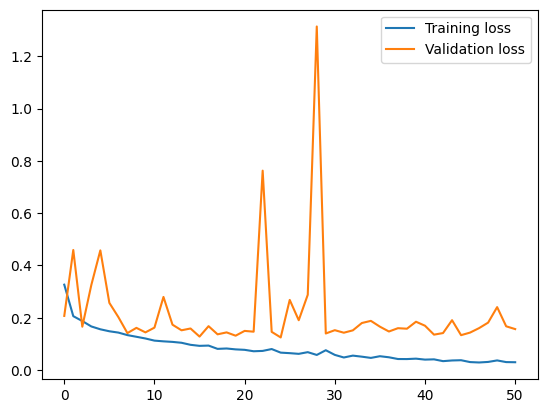

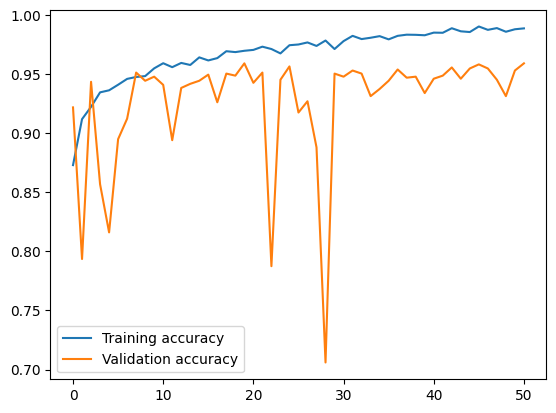

RESULTADOS EN TEST:
Pérdida en test: 0.13120751082897186
Accuracy en test: 0.9613715410232544


In [ ]:
# Con 25 épocas es suficiente para alcanzar la mayor precisión.
model_defrost_conv5_data_augmentation_lr_SGD(10, 50, 'densenet201')

In [ ]:
def model_defrost_conv5_data_augmentation_lr_SGD_II(epochs_frozen, epochs_defrost, dense_type):

    ############################################################
    ### Transfer learning
    ############################################################

    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.1),
    ])

    # map aplica la función pasada como primer argumento a todos los elemetos
    # del dataset y devuelve un nuevo dataset que contiene los elementos
    # transformados
    train_aug = train.map(lambda x, y: (data_augmentation(x, training=True), y))
        
    densenet = cargaDenseNet(dense_type)

    densenet.trainable = False

    inputs = keras.Input(shape=(image_size,image_size,channels))
    x = preprocess_input(inputs)
    x = densenet(x, training = False)
    outputs = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    hist = model.fit(
        train_aug,
        # batch_size = batch_size,
        epochs = epochs_frozen,
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist)

    print('RESULTADOS EN TEST:')
    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])

    del score

    ############################################################
    ### Fine-tuning
    ############################################################

    total_epochs = epochs_frozen + epochs_defrost
    
    checkpoint_filepath = '/tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='accuracy',
        mode='max',
        save_best_only=True
    )

    my_layer = model.get_layer(dense_type)
    my_layer.trainable = True

    for layer in my_layer.layers:
        if ('conv4' in layer.name) or ('conv5' in layer.name) :
            #print(layer.name)
            layer.trainable = True
        else:
            layer.trainable = False

    # Cuantas capas tiene el modelo DenseNet121
    # print("Número de capas de DenseNet121: ", len(densenet.layers))

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, nesterov = True, momentum = 0.9),
        metrics=["accuracy"]
    )

    model.summary()

    hist_fine = model.fit(
        train_aug,
        # batch_size = batch_size,
        epochs = total_epochs,
        callbacks=[model_checkpoint_callback],
        initial_epoch = hist.epoch[-1],
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist_fine)

    print('RESULTADOS EN TEST:')

    model.load_weights(checkpoint_filepath)
    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])


    del model, score, hist, densenet, hist_fine

29097984/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 75, 75, 3)        0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                              

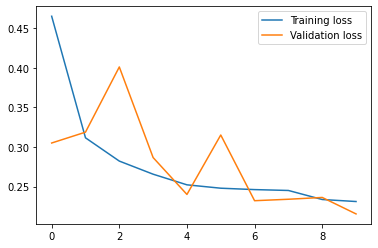

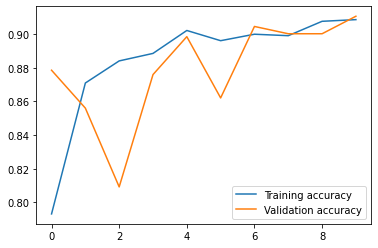

RESULTADOS EN TEST:
Pérdida en test: 0.24341543018817902
Accuracy en test: 0.9032118320465088
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 75, 75, 3)        0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                 

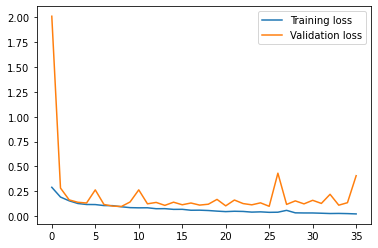

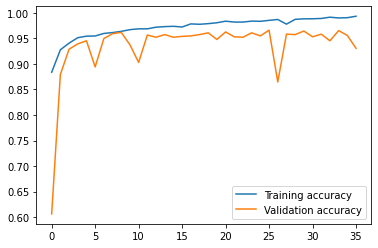

RESULTADOS EN TEST:
Pérdida en test: 0.4011174738407135
Accuracy en test: 0.9314236044883728


In [ ]:
model_defrost_conv5_data_augmentation_lr_SGD_II(10, 35, 'densenet121')

51888128/51877672 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet169 (Functional)    (None, 1664)              12642

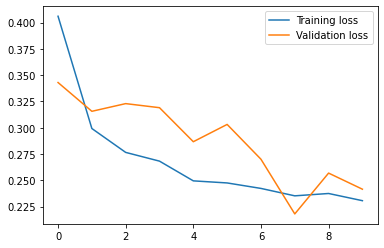

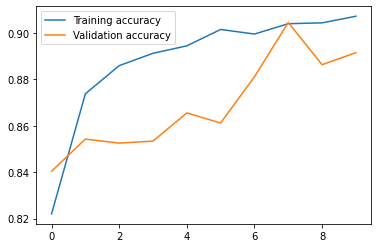

RESULTADOS EN TEST:
Pérdida en test: 0.240651473402977
Accuracy en test: 0.9071180820465088
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet169 (Functional)    (Non

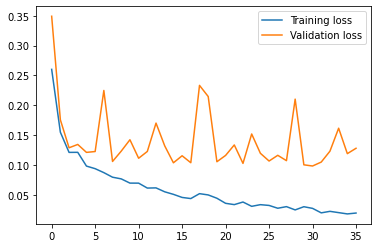

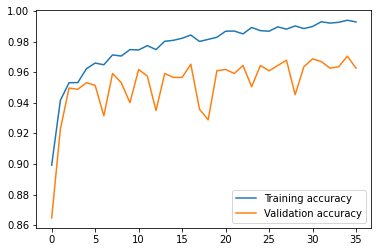

RESULTADOS EN TEST:
Pérdida en test: 0.16081690788269043
Accuracy en test: 0.9635416865348816


In [ ]:
model_defrost_conv5_data_augmentation_lr_SGD_II(10, 35, 'densenet169')

74850304/74836368 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 75, 75, 3)        0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 1920)              18321984  
                                                              

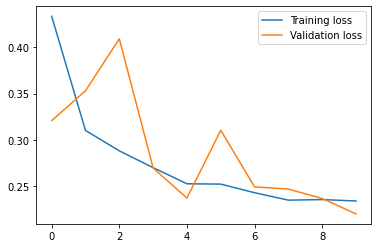

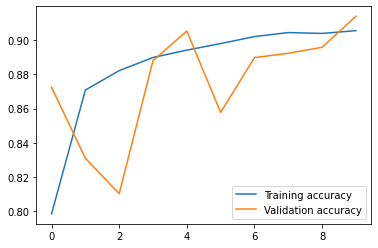

RESULTADOS EN TEST:
Pérdida en test: 0.22600609064102173
Accuracy en test: 0.9162326455116272
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 75, 75, 3)        0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 1920)              18321984  
                                 

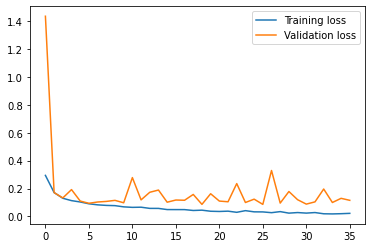

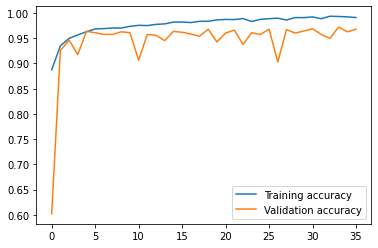

RESULTADOS EN TEST:
Pérdida en test: 0.18050745129585266
Accuracy en test: 0.9518229365348816


In [ ]:
model_defrost_conv5_data_augmentation_lr_SGD_II(10, 35, 'densenet201')

In [10]:
def model_defrost_conv5_data_augmentation_lr_SGD_III(epochs_frozen, epochs_defrost, dense_type):

    ############################################################
    ### Transfer learning
    ############################################################

    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.1),
    ])

    # map aplica la función pasada como primer argumento a todos los elemetos
    # del dataset y devuelve un nuevo dataset que contiene los elementos
    # transformados
    train_aug = train.map(lambda x, y: (data_augmentation(x, training=True), y))
        
    densenet = cargaDenseNet(dense_type)

    densenet.trainable = False

    inputs = keras.Input(shape=(image_size,image_size,channels))
    x = preprocess_input(inputs)
    x = densenet(x, training = False)
    outputs = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    hist = model.fit(
        train_aug,
        # batch_size = batch_size,
        epochs = epochs_frozen,
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist)

    print('RESULTADOS EN TEST:')
    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])

    del score

    ############################################################
    ### Fine-tuning
    ############################################################

    total_epochs = epochs_frozen + epochs_defrost
    
    checkpoint_filepath = '/tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='accuracy',
        mode='max',
        save_best_only=True
    )

    my_layer = model.get_layer(dense_type)
    my_layer.trainable = True

    for layer in my_layer.layers:
        if ('conv4' in layer.name) or ('conv5' in layer.name) or ('conv3' in layer.name):
            #print(layer.name)
            layer.trainable = True
        else:
            layer.trainable = False

    # Cuantas capas tiene el modelo DenseNet121
    # print("Número de capas de DenseNet121: ", len(densenet.layers))

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, nesterov = True, momentum = 0.9),
        metrics=["accuracy"]
    )

    model.summary()

    hist_fine = model.fit(
        train_aug,
        # batch_size = batch_size,
        epochs = total_epochs,
        callbacks=[model_checkpoint_callback],
        initial_epoch = hist.epoch[-1],
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist_fine)

    print('RESULTADOS EN TEST:')

    model.load_weights(checkpoint_filepath)
    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])


    del model, score, hist, densenet, hist_fine

29097984/29084464 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 75, 75, 3)        0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                              

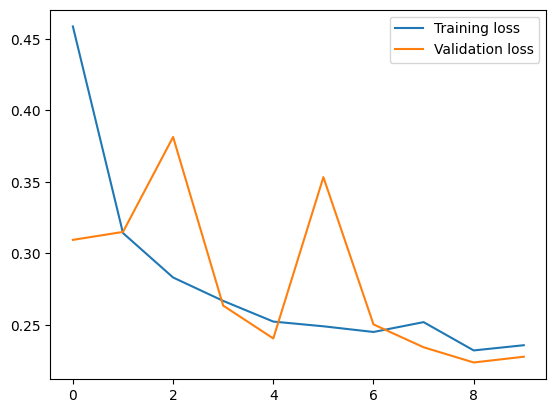

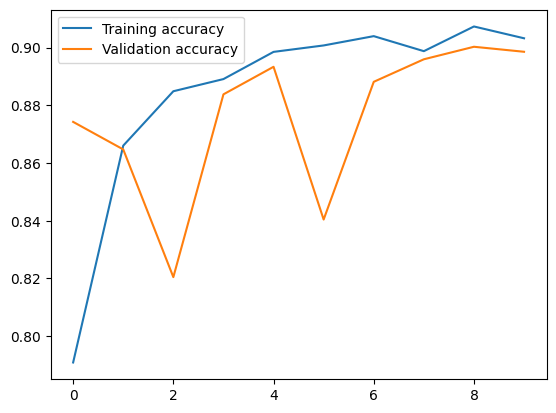

RESULTADOS EN TEST:
Pérdida en test: 0.2472260296344757
Accuracy en test: 0.8997395634651184
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 75, 75, 3)        0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                  

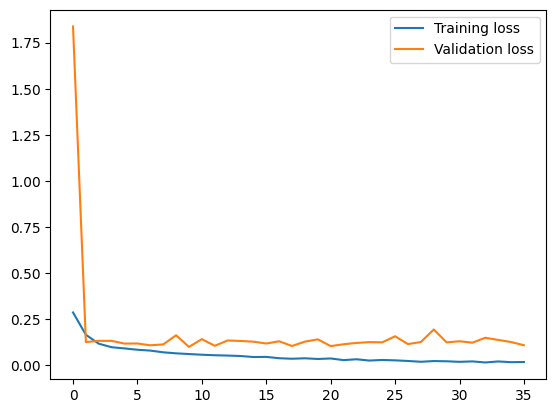

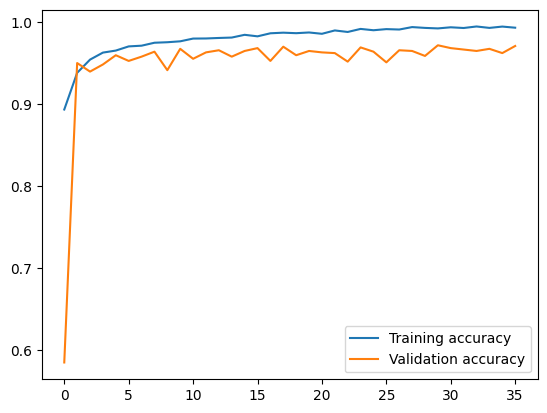

RESULTADOS EN TEST:
Pérdida en test: 0.13080452382564545
Accuracy en test: 0.9661458134651184


In [ ]:
model_defrost_conv5_data_augmentation_lr_SGD_III(10, 35, 'densenet121')

51888128/51877672 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 75, 75, 3)        0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet169 (Functional)    (None, 1664)              12642880  
                                                              

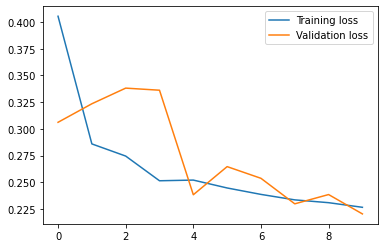

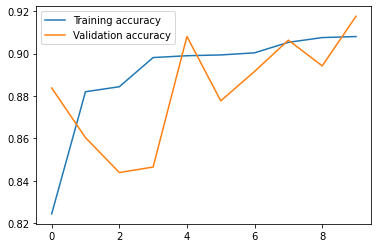

RESULTADOS EN TEST:
Pérdida en test: 0.23183761537075043
Accuracy en test: 0.9066840410232544
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 75, 75, 3)        0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet169 (Functional)    (None, 1664)              12642880  
                                 

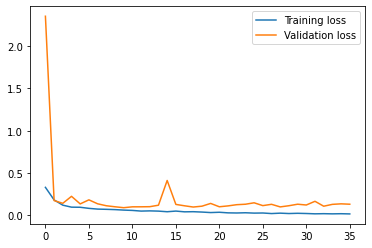

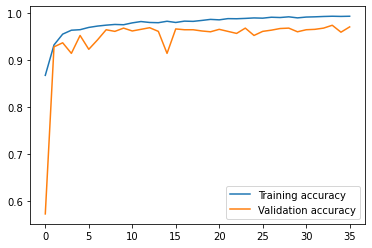

RESULTADOS EN TEST:
Pérdida en test: 0.1275711953639984
Accuracy en test: 0.9704861044883728


In [11]:
model_defrost_conv5_data_augmentation_lr_SGD_III(10, 35, 'densenet169')

74850304/74836368 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 1920)              18321

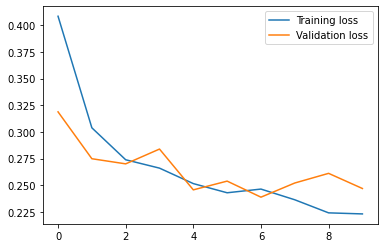

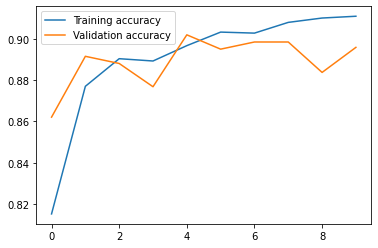

RESULTADOS EN TEST:
Pérdida en test: 0.2427043318748474
Accuracy en test: 0.9053819179534912
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (No

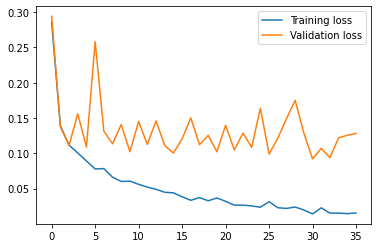

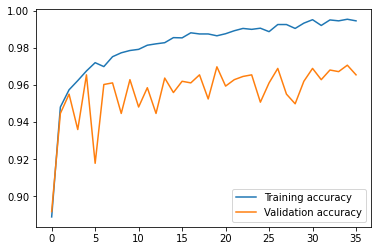

RESULTADOS EN TEST:
Pérdida en test: 0.11069173365831375
Accuracy en test: 0.9743923544883728


In [12]:
model_defrost_conv5_data_augmentation_lr_SGD_III(10, 35, 'densenet201')

In [14]:
def model_defrost_conv5_data_augmentation_lr_SGD_IIII(epochs_frozen, epochs_defrost, dense_type):

    ############################################################
    ### Transfer learning
    ############################################################

    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.1),
    ])

    # map aplica la función pasada como primer argumento a todos los elemetos
    # del dataset y devuelve un nuevo dataset que contiene los elementos
    # transformados
    train_aug = train.map(lambda x, y: (data_augmentation(x, training=True), y))
        
    densenet = cargaDenseNet(dense_type)

    densenet.trainable = False

    inputs = keras.Input(shape=(image_size,image_size,channels))
    x = preprocess_input(inputs)
    x = densenet(x, training = False)
    outputs = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    hist = model.fit(
        train_aug,
        # batch_size = batch_size,
        epochs = epochs_frozen,
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist)

    print('RESULTADOS EN TEST:')
    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])

    del score

    ############################################################
    ### Fine-tuning
    ############################################################

    total_epochs = epochs_frozen + epochs_defrost
    
    checkpoint_filepath = '/tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='accuracy',
        mode='max',
        save_best_only=True
    )

    my_layer = model.get_layer(dense_type)
    my_layer.trainable = True

    for layer in my_layer.layers:
        if ('conv4' in layer.name) or ('conv5' in layer.name) or ('conv3' in layer.name) or ('conv2' in layer.name):
            #print(layer.name)
            layer.trainable = True
        else:
            layer.trainable = False

    # Cuantas capas tiene el modelo DenseNet121
    # print("Número de capas de DenseNet121: ", len(densenet.layers))

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, nesterov = True, momentum = 0.9),
        metrics=["accuracy"]
    )

    model.summary()

    hist_fine = model.fit(
        train_aug,
        # batch_size = batch_size,
        epochs = total_epochs,
        callbacks=[model_checkpoint_callback],
        initial_epoch = hist.epoch[-1],
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist_fine)

    print('RESULTADOS EN TEST:')

    model.load_weights(checkpoint_filepath)
    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])
    
    model.save(dense_type + 'IIII.h5')


    del model, score, hist, densenet, hist_fine

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_7 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                           

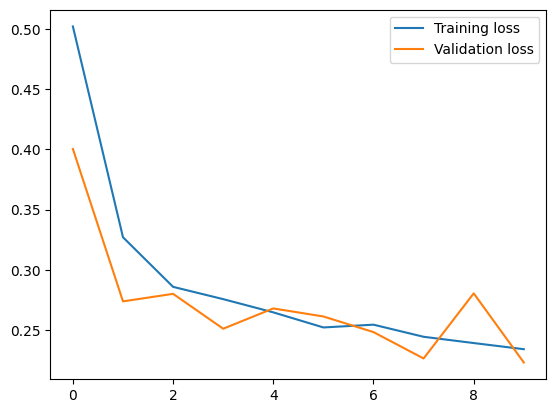

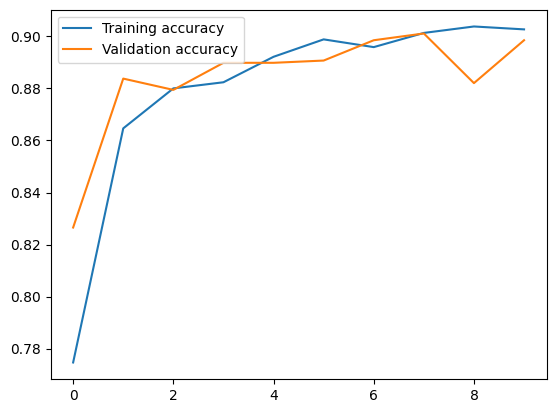

RESULTADOS EN TEST:
Pérdida en test: 0.24632686376571655
Accuracy en test: 0.9001736044883728
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_7 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (N

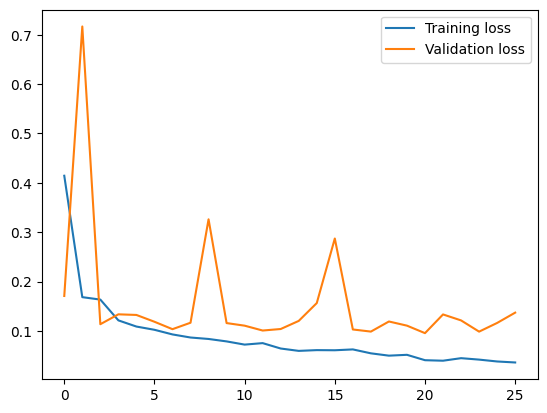

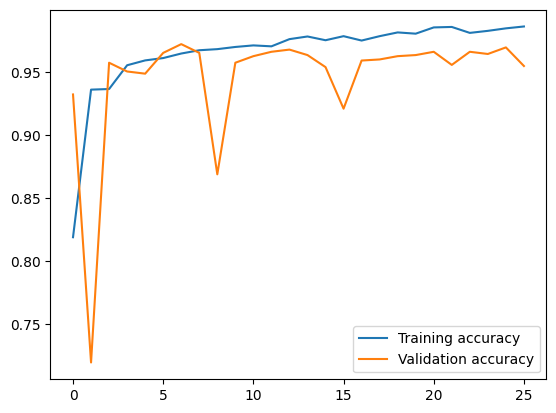

RESULTADOS EN TEST:
Pérdida en test: 0.12000857293605804
Accuracy en test: 0.9626736044883728


In [15]:
model_defrost_conv5_data_augmentation_lr_SGD_IIII(10, 25, 'densenet121')

51888128/51877672 [==============================] - 8s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 75, 75, 3)        0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet169 (Functional)    (None, 1664)              12642880  
                                                              

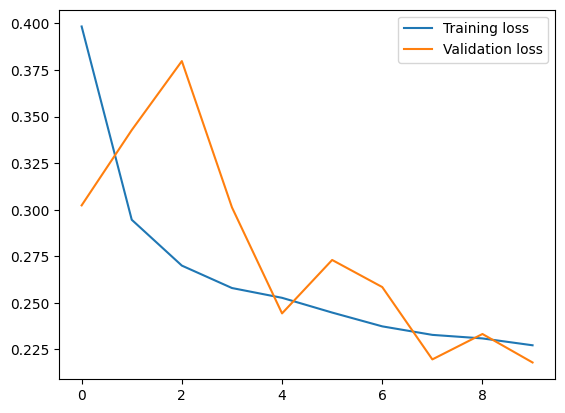

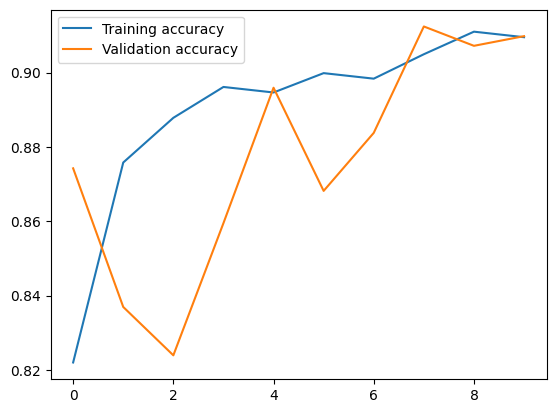

RESULTADOS EN TEST:
Pérdida en test: 0.2255127727985382
Accuracy en test: 0.9140625
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 75, 75, 3)        0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet169 (Functional)    (None, 1664)              12642880  
                                           

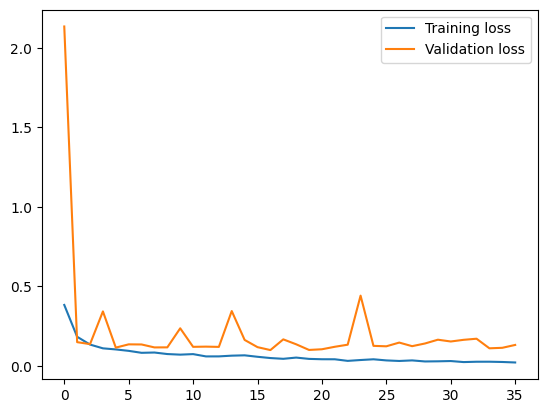

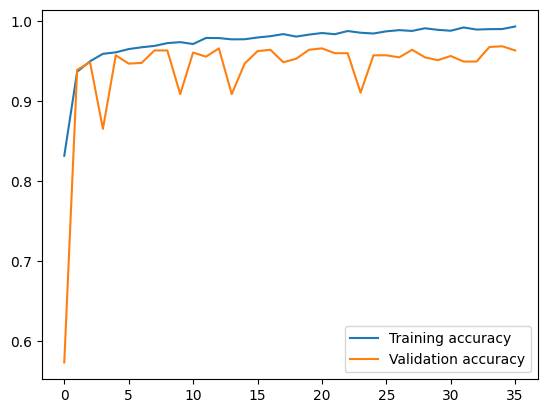

RESULTADOS EN TEST:
Pérdida en test: 0.1135651022195816
Accuracy en test: 0.96875


In [9]:
model_defrost_conv5_data_augmentation_lr_SGD_IIII(10, 35, 'densenet169')

74850304/74836368 [==============================] - 15s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 1920)              1832

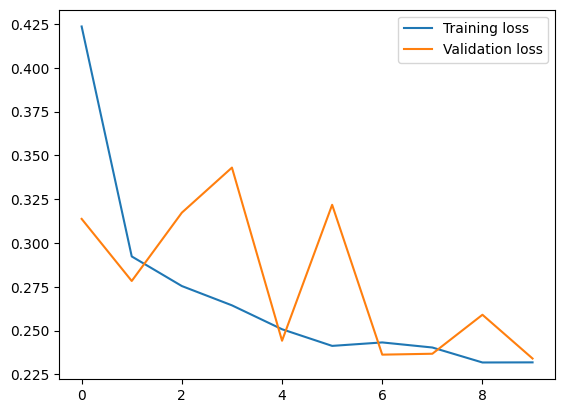

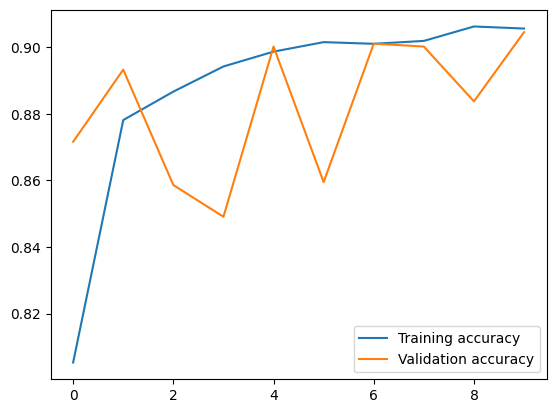

RESULTADOS EN TEST:
Pérdida en test: 0.2300824522972107
Accuracy en test: 0.90625
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 1920)  

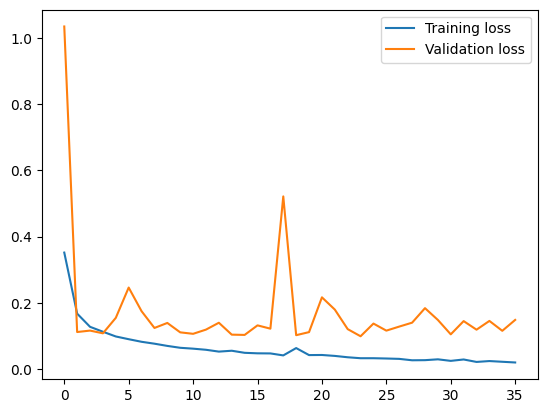

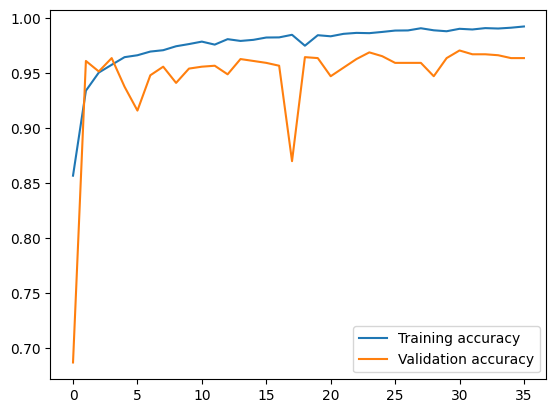

RESULTADOS EN TEST:
Pérdida en test: 0.10975278168916702
Accuracy en test: 0.97265625


In [10]:
model_defrost_conv5_data_augmentation_lr_SGD_IIII(10, 35, 'densenet201')

In [ ]:
densenet = cargaDenseNet('densenet121')
densenet.summary()

29097984/29084464 [==============================] - 1s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 81, 81, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 38, 38, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 38, 38, 64)   256         ['conv1/conv[0][0]']             
                       